Importing packages

In [ ]:
import pathlib
import os
import re
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal as signal
idx = pd.IndexSlice

---
>> **TASK 1**
>>
>> Clean the data in A3/unclean.csv with python (4 points)
>>
>> - Import csv file
>> - Create DataFrame with labels
>> - Clean and prepare data for analysis and visualization
>> - Plot signals from columns (fix errors)
>>
---

In [7]:
rr = pd.read_csv("unclean.csv", delimiter=";",
                 skiprows=6, names=['I', 'A', 'B', 'C'])
rr.head()

,I,A,B,C
0,0,"0,0V","1,0cm","0,0ms"
1,1,"0,012566287931117902V","1,0cm","0,001ms"
2,2,"0,025132079766705215V","1,0cm","0,002ms"
3,3,"0,03769687943081635V","1,0cm","0,003ms"
4,4,"0,05026019088667496V","1,0cm","0,004ms"


In [8]:
rr.columns

Index(['I', 'A', 'B', 'C'], dtype='object')

In [9]:
rr.shape

(10000, 4)

In [10]:
rr["A"] = pd.to_numeric(rr["A"].str.replace(",", ".").str.strip("V"))
rr["B"] = pd.to_numeric(rr["B"].str.replace(",", ".").str.strip("cm"))
rr["C"] = pd.to_numeric(rr["C"].str.replace(",", ".").str.strip("ms"))
rr.head()

,I,A,B,C
0,0,0.000000,1.0,0.000
1,1,0.012566,1.0,0.001
2,2,0.025132,1.0,0.002
3,3,0.037697,1.0,0.003
4,4,0.050260,1.0,0.004


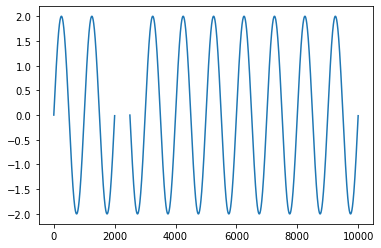

In [13]:
rr["A"].plot();

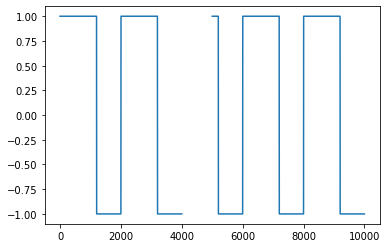

In [14]:
rr["B"].plot();

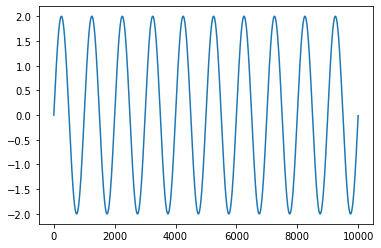

In [15]:
rr["A"].interpolate(method="polynomial", order=7).plot();

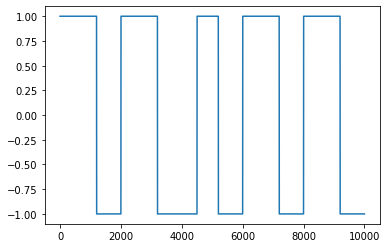

In [16]:
rr["B"].interpolate(method="nearest").plot();

---
>> **TASK 2**
>>
>> Recreate signals with python (3 points)
>>
>> a)
>>
>> ![waveA](waveA.png)
>>
>> b)
>>
>> ![waveB](waveB.png)
>>
---

In [17]:
def gen_wave(Hz, sample_rate, length_sec, phase, amplitude):
    t = np.linspace(0, length_sec, int(
        length_sec * sample_rate), endpoint=False)
    x = amplitude * np.sin(Hz * 2 * np.pi * t + phase)
    return x

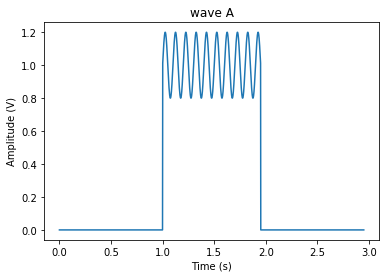

In [19]:
sample_rate = 1000
zeros = np.zeros(sample_rate * 1)
wave = gen_wave(10, sample_rate, 0.95, 0, 0.2) + 1
banga = np.concatenate((zeros, wave, zeros), axis=0)
t = np.linspace(0, len(banga) / sample_rate, len(banga))
plt.plot(t, banga)
plt.title("wave A")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)");

 wave B

In [20]:
sample_rate = 1000
x = np.random.random(sample_rate) / 10

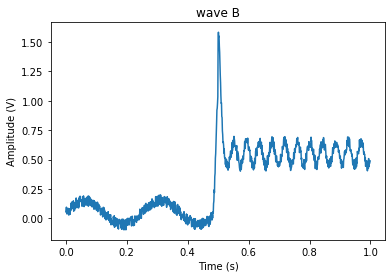

In [22]:
s1 = 10
t = np.arange(sample_rate)
spike_train = np.exp(-(((t - (sample_rate * 0.5)) / (s1)) ** 2))
wave = np.concatenate(
    (
        gen_wave(4, sample_rate, 0.5, 0, 0.1),
        gen_wave(24, sample_rate, 0.5, 0, 0.1) + 0.5,
    ),
    axis=0,
)
wave += spike_train
wave += x
plt.plot(t / 1000, wave)
plt.title("wave B")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)");

---
>> **TASK 3**
>>
>> ERP calculation (3 points)
>>
>> Equal probability (50/50) Go/NoGo paradigm (https://en.wikipedia.org/wiki/Go/no_go) with two types of stimuli was used, as described by Barry et al. (Barry et al. 2007). The auditory equiprobable Go/NoGo task requires a physical response to Go stimuli, while no response is required to NoGo stimuli. Subjects received 150 tones (75 of Go and 75 of NoGo type) of 50 ms duration, with 5 ms rise/fall times, presented via headphones at 60 dB SPL with a fixed stimulus onset asynchrony of 1100 ms. Half of the tones were 1000 Hz and half were 1500 Hz, presented in a random order. Participants were required to respond by pressing a button with their right index finger to the tone with the target frequency, which was balanced between subjects.
>>
>> - GO sound marked as 1
>> - NoGo sound marked as 2
>> - Button press marked as 10.
>>
>> Data:
>>  - EEG: ~/Documents/bioa/exam/A3/*EEG.csv    data columns: Fz, Cz, Pz, Oz channels and time in milliseconds
>>  - Event file in: ~/Documents/bioa/exam/A3/*events.csv    data columns: mark, time index
>>
>> MUST BE DONE IN PANDAS
>>
>> 1. Make a loop to find and import EEG and event files (make sure events EEG data is imported from the same subject).
>> 2. Adjust imported files. Extract markers (-500, +1000 ms)
>> 3. Average subjects EEG around given markers. 1 ERP for GO condition and 1 ERP for NOGO condition from 1 subject for every channel
>> 4. Final pandas structure must hold all subjects ERPs from all channels
>> 5. Calculate grand average (average between subjects) ERPs for all channels, subtract baseline. Plot results.
>>
>> More info on waveforms A3/falkenstein1999.pdf
>>
---

In [23]:
datadir = "/home/aleks/Documents/bioa/exam/A3/GNG/"

In [27]:
dataDir = pathlib.Path(datadir)
dd = dataDir.glob("**/*EEG.csv")
ddd = [str(item) for item in dd]
ddd.sort()
ddd

['/home/aleks/Documents/bioa/exam/A3/GNG/10EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/1EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/2EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/3EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/4EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/5EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/6EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/7EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/8EEG.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/9EEG.csv']

In [28]:
dl = dataDir.glob("**/*event.csv")
dll = [str(item) for item in dl]
dll.sort()
dll

['/home/aleks/Documents/bioa/exam/A3/GNG/10event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/1event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/2event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/3event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/4event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/5event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/6event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/7event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/8event.csv',
 '/home/aleks/Documents/bioa/exam/A3/GNG/9event.csv']

In [29]:
subject_array = [f"subj{item}" for item in np.arange(1, len(dll) + 1)]
subject_array

['subj1',
 'subj2',
 'subj3',
 'subj4',
 'subj5',
 'subj6',
 'subj7',
 'subj8',
 'subj9',
 'subj10']

In [30]:
columns = pd.MultiIndex.from_product(
    [subject_array, ["Fz", "Cz", "Pz", "Oz"]], names=["subject", "index"],
)
gng_go = pd.DataFrame(columns=columns, index=np.arange(0, 3072))
gng_go

subject subj1                subj2                subj3       ... subj8       \
index      Fz   Cz   Pz   Oz    Fz   Cz   Pz   Oz    Fz   Cz  ...    Pz   Oz   
0         NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
1         NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
2         NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
3         NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
4         NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
5         NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
6         NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
...       ...  ...  ...  ...   ...  ...  ...  ...   ...  ...  ...   ...  ...   
3065      NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
3066      NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
3067      NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
3068      NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
3069      NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
3070      NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   
3071      NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN  NaN  ...   NaN  NaN   

subject subj9                subj10                 
index      Fz   Cz   Pz   Oz     Fz   Cz   Pz   Oz  
0         NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
1         NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
...       ...  ...  ...  ...    ...  ...  ...  ...  
3065      NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
3066      NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
3067      NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
3068      NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
3069      NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
3070      NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  
3071      NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  

[3072 rows x 40 columns]

In [31]:
gng_nogo = pd.DataFrame(columns=columns, index=np.arange(0, 3072))
subj = 0
for eeg_name, event_name in zip(ddd, dll):
    subj += 1
    #  eeg_name = ddd[1]
    #  event_name = dll[1]
    subj_name = f"subj{subj}"
    EEGdata = pd.read_csv(eeg_name, names=["Fz", "Cz", "Pz", "Oz", "time"])
    #  EEGdata.head()
    events = pd.read_csv(event_name, names=["event", "time_index"], dtype=int,)
    (events["event"].shift(-1) - events["event"])
    go = events[(events["event"].shift(-1) - events["event"]) == 9]
    #  go.shape
    #  go.head()
    nogo = events[(events["event"].shift(-1) - events["event"]) == -1]
    nogo2 = events[(events["event"].shift(-1) - events["event"]) == 0]
    nogo = nogo.append(nogo2).sort_index()
    nogo = nogo[nogo["event"] == 2]
    #  nogo.shape
    #  nogo.head()
    # ERP limits - 500 + 1000 ms
    fs = int(round(EEGdata["time"].shape[0] / EEGdata["time"].iloc[-1] * 1000))
    idx500 = int(fs * 0.5)
    idx1000 = int(fs * 1)
    #  ERP
    go_start = (go["time_index"] - idx500).to_list()
    go_end = (go["time_index"] + idx1000).to_list()
    nogo_start = (nogo["time_index"] - idx500).to_list()
    nogo_end = (nogo["time_index"] + idx1000).to_list()
    ND = pd.DataFrame()
    for go_st, go_e in zip(go_start, go_end):
        ND = ND.append(EEGdata[go_st:go_e].reset_index()
                       ).drop(labels="index", axis=1)
    #  ND.head()
    #  ND.shape[0] / 75
    avg_go = ND.reset_index().groupby("index").mean()
    avg_go["time"] = np.linspace(-500, 1000, 3072)
    ND = pd.DataFrame()
    for nogo_st, nogo_e in zip(nogo_start, nogo_end):
        ND = ND.append(EEGdata[nogo_st:nogo_e].reset_index()).drop(
            labels="index", axis=1
        )
    avg_nogo = ND.reset_index().groupby("index").mean()
    avg_nogo["time"] = np.linspace(-500, 1000, 3072)
    #  baseline correction
    gng_go[subj_name] = avg_go.loc[:, "Fz":"Oz"] - \
        avg_go.loc[0:1000, "Fz":"Oz"].mean()
    gng_nogo[subj_name] = (
        avg_nogo.loc[:, "Fz":"Oz"] - avg_nogo.loc[0:1000, "Fz":"Oz"].mean()
    )

Grand AVG

NameError: name 'gng_go' is not defined

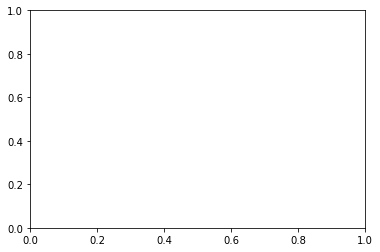

In [1]:
fig = plt.figure()
ax = plt.axes()
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_go.loc[:, idx[:, "Fz"]].mean(axis=1).to_numpy(),
    label="Go Fz",
)
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_nogo.loc[:, idx[:, "Fz"]].mean(axis=1).to_numpy(),
    label="NoGo Fz",
)
ax.set_xlabel("time (ms)")  # add x label
ax.vlines(0, -3, 2, linestyle="--", color="gray")
ax.set_xlim(-100, 1000)
plt.legend();
#  fig.savefig("Fz.png")

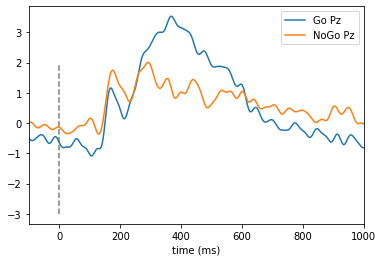

In [36]:
fig = plt.figure()
ax = plt.axes()
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_go.loc[:, idx[:, "Pz"]].mean(axis=1).to_numpy(),
    label="Go Pz",
)
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_nogo.loc[:, idx[:, "Pz"]].mean(axis=1).to_numpy(),
    label="NoGo Pz",
)
ax.set_xlabel("time (ms)")  # add x label
ax.vlines(0, -3, 2, linestyle="--", color="gray")
ax.set_xlim(-100, 1000)
plt.legend();
#  fig.savefig("Pz.png")

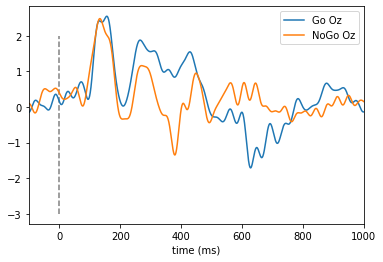

In [34]:
fig = plt.figure()
ax = plt.axes()
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_go.loc[:, idx[:, "Oz"]].mean(axis=1).to_numpy(),
    label="Go Oz",
)
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_nogo.loc[:, idx[:, "Oz"]].mean(axis=1).to_numpy(),
    label="NoGo Oz",
)
ax.set_xlabel("time (ms)")  # add x label
ax.vlines(0, -3, 2, linestyle="--", color="gray")
ax.set_xlim(-100, 1000)
plt.legend();
#  fig.savefig("Oz.png")

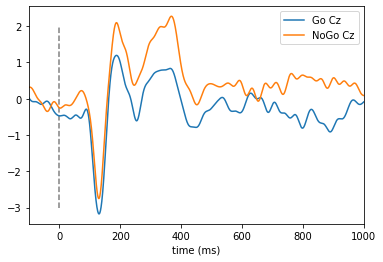

In [35]:
fig = plt.figure()
ax = plt.axes()
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_go.loc[:, idx[:, "Cz"]].mean(axis=1).to_numpy(),
    label="Go Cz",
)
ax.plot(
    np.linspace(-500, 1000, 3072),
    gng_nogo.loc[:, idx[:, "Cz"]].mean(axis=1).to_numpy(),
    label="NoGo Cz",
)
ax.set_xlabel("time (ms)")  # add x label
ax.vlines(0, -3, 2, linestyle="--", color="gray")
ax.set_xlim(-100, 1000)
plt.legend();
#  fig.savefig("Cz.png")